In [119]:
import numpy as np
import pandas as pd
from IPython.display import display


class connect_x:

    def __init__(self):
        self.board_height = 5
        self.board_width = 5
        self.board_state = np.zeros([self.board_height, self.board_width], dtype=np.int8)
        self.players = {'p1': 1, 'p2': 2}
        self.isDone = False
        self.reward = {'win': 1, 'draw': 0.5, 'lose': -1}
        self.in_a_row = 4
    
    def render(self):
        rendered_board_state = self.board_state.copy().astype(str) #dropped np.str since there was a warning in the demo. Now just str
        rendered_board_state[self.board_state == 0] = ' '
        rendered_board_state[self.board_state == 1] = 'O'
        rendered_board_state[self.board_state == 2] = 'X'
        display(pd.DataFrame(rendered_board_state))
    
    def reset(self):
        self.__init__()
        
    def get_available_actions(self):
        available_pos = []
        for i in range(self.board_width):
            for j in range(self.board_height):
                if np.sum(self.board_state[i, j]) == 0:
                    available_pos.append([i,j])
        return available_pos
        # available_cols = []
        # for j in range(self.board_width):
        #     if np.sum([self.board_state[:, j] == 0]) != 0:
        #         available_cols.append(j)
        # return available_cols
    
    def check_game_done(self, player):
        if player == 'p1':
            check = "1 " * self.in_a_row
            check = check[0:-1]
        else:
            check = "2 " * self.in_a_row
            check = check[0:-1]
        
        # check vertically then horizontally
        for j in range(self.board_width):
            if check in np.array_str(self.board_state[:, j]):
                self.isDone = True
        for i in range(self.board_height):
            if check in np.array_str(self.board_state[i, :]):
                self.isDone = True
        
        # check left diagonal and right diagonal
        for k in range(0, self.board_height - 4 + 1):
            left_diagonal = np.array([self.board_state[k + d, d] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d + k, self.board_width - d - 1] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                self.isDone = True
        for k in range(1, self.board_width - 4 + 1):
            left_diagonal = np.array([self.board_state[d, d + k] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d, self.board_width - 1 - k - d] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                self.isDone = True
        
        ########print(np.sum([self.board_state == 0]))
        if self.isDone:
            return self.reward['win']
        # check for draw
        elif np.sum([self.board_state == 0]) == 0:
            self.isDone = True
            return self.reward['draw']
        else:
            return 0.
        
    def make_move(self, a, player):
        # check if move is valid
        if a in self.get_available_actions():
            self.board_state[a[0], a[1]] = self.players[player]
        else:
            print('Move is invalid')
            self.render()
        # # check if move is valid
        # if a in self.get_available_actions():
        #     i = np.sum([self.board_state[:, a] == 0]) - 1
        #     self.board_state[i, a] = self.players[player]
        # else:
        #     print('Move is invalid')
        #     self.render()

        reward = self.check_game_done(player)
        ########print( env.board_state, env.isDone, "IS DONE RESULT")
        
        # give feedback as new state and reward
        return self.board_state.copy(), reward

env = connect_x()
#print(env.board_state)

In [121]:
import random

# memory block for deep q learning
class replayMemory:
    def __init__(self):
        self.memory = []
        
    def dump(self, transition_tuple):
        self.memory.append(transition_tuple)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
memory = replayMemory()

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F

height = env.board_height
width = env.board_width

class DQN(nn.Module):
    
    def __init__(self, outputs):
        super(DQN, self).__init__()
        # 6 by 7, 10 by 11 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        
        linear_input_size = width * height * 32
        self.MLP1 = nn.Linear(linear_input_size, 50)
        self.MLP2 = nn.Linear(50, 50)
        self.MLP3 = nn.Linear(50, 50)
        self.MLP4 = nn.Linear(50, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        # flatten the feature vector except batch dimension
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.MLP1(x))
        x = F.leaky_relu(self.MLP2(x))
        x = F.leaky_relu(self.MLP3(x))
        return self.MLP4(x)

In [123]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


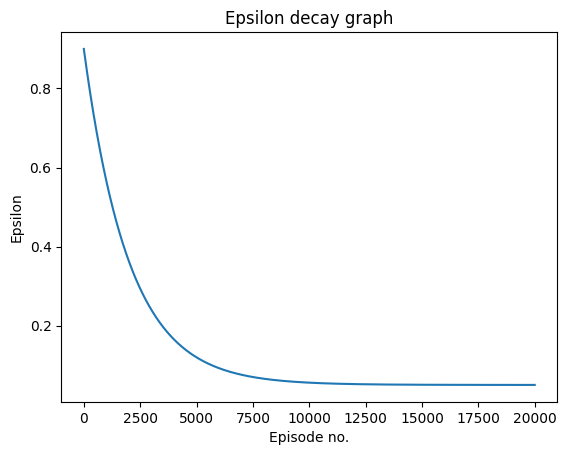

In [124]:
import matplotlib.pyplot as plt
# epilson decay graph
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000

steps_done = np.arange(20000)
eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * steps_done / EPS_DECAY)
plt.plot(steps_done, eps)
plt.title('Epsilon decay graph')
plt.xlabel('Episode no.')
plt.ylabel('Epsilon')
plt.show()

In [125]:
import torch.optim as optim
import math

BATCH_SIZE = 256
GAMMA = 0.999

# get max no. of actions from action space
n_actions = env.board_width * env.board_height

height = env.board_height
width = env.board_width

policy_net = DQN(n_actions).to(device)
# target_net will be updated every n episodes to tell policy_net a better estimate of how far off from convergence
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# set target_net in testing mode
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())

def select_action(state, available_actions, steps_done=None, training=True):
    # batch and color channel
    state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
    #print(state, state.shape)
    epsilon = random.random()
    if training:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    else:
        eps_threshold = 0
    
    # follow epsilon-greedy policy
    if epsilon > eps_threshold:
        with torch.no_grad():
            # action recommendations from policy net
            # print(policy_net(state), "policy net state")
            # print(policy_net(state)[0], "first entry")
            # print(policy_net(state)[0, :], "r actions")
            r_actions = policy_net(state)[0, :]
            state_action_values = [r_actions[action] for action in available_actions]
            #print(state_action_values)
            state_action_values = [pair[0] + pair[1] for pair in state_action_values]
            #print(state_action_values, "fixed")
            # print(state_action_values[0][0], state_action_values[0][1], "first entry")
            # print(state_action_values[0][0]+ state_action_values[0][1], "first sum")
            argmax_action = np.argmax(state_action_values)
            #print(argmax_action, state_action_values)
            greedy_action = available_actions[argmax_action]
            return greedy_action
    else:
        ########print(available_actions)
        return random.choice(available_actions)

In [126]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*[(np.expand_dims(m[0], axis=0), \
                                        [m[1]], m[2], np.expand_dims(m[3], axis=0)) for m in transitions])
    # tensor wrapper
    #print(action_batch, "action batch")
    #was to get the action batch tensor size to match that of state_batch further down... 256 by 1 by 5 by 5 versus action was 256 by 1 by 2 now 256 by 1
    action_batch = [[pair[0][0]] for pair in action_batch]
    #action_batch = [pair[0] for pair in action_batch]
    #print(action_batch, "action batch")
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    action_batch = torch.tensor(action_batch, dtype=torch.long, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)
    
    # for assigning terminal state value = 0 later
    non_final_mask = torch.tensor(tuple(map(lambda s_: s_[0] is not None, next_state_batch)), device=device)
    non_final_next_state = torch.cat([torch.tensor(s_, dtype=torch.float, device=device).unsqueeze(0) for s_ in next_state_batch if s_[0] is not None])
    
    # prediction from policy_net
    #######################################
    #Don't know how to update the dimensions so that they fit/pull correctly...might just give up
    #######################################
    #print(state_batch, state_batch.shape, "batch")
    #print(action_batch, action_batch.shape, "action")
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    #print(state_action_values, "Action Vals")
    
    # truth from target_net, initialize with zeros since terminal state value = 0
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad
    next_state_values[non_final_mask] = target_net(non_final_next_state).max(1)[0].detach() #get value of next state values
    # compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch 

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1)) # torch.tensor.unsqueeze returns a copy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [127]:
# random agent
def random_agent(actions):
    return random.choice(actions)

# win rate test
def win_rate_test():
    win_moves_taken_list = []
    win = []
    for i in range(100):
        env.reset()
        win_moves_taken = 0

        while not env.isDone:
            state = env.board_state.copy()
            available_actions = env.get_available_actions()
            #####print(env.board_state, available_actions, "before p1 move")
            action = select_action(state, available_actions, training=False)
            state, reward = env.make_move(action, 'p1')
            win_moves_taken += 1
            #####print(env.board_state, "after p1 move")

            if reward == 1:
                win_moves_taken_list.append(win_moves_taken)
                win.append(1)
                break
            ##### Added because this will accommodate for the scenarios when draw on odd by odd boards...
            ##### p1 ended the game, but there is no check for the draw after an odd number of moves...
            if env.isDone:
                break

            available_actions = env.get_available_actions()
            #####print(env.board_state, available_actions, "before p2 move")
            action = random_agent(available_actions)
            state, reward = env.make_move(action, 'p2')
            #####print(env.board_state, "after p2 move")

    return sum(win)/100, sum(win_moves_taken_list)/len(win_moves_taken_list)

In [128]:
# avoid resetting
steps_done = 0
training_history = []

In [129]:
from itertools import count


In [130]:
# [print(count())]
# for t in count():
#     print(t)
#     available_actions = env.get_available_actions()
#     action_p1 = select_action(state_p1, available_actions, steps_done)

In [131]:

num_episodes = 350
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 3

for i in range(num_episodes): 
    env.reset()
    state_p1 = env.board_state.copy()

    # record every 10 epochs
    if i % 10 == 9:
        win_rate, moves_taken = win_rate_test()
        training_history.append([i + 1, win_rate, moves_taken])
        th = np.array(training_history)
        # print training message every 100 epochs
        if i % 100 == 99:
            print('Episode {}: | win_rate: {} | moves_taken: {}'.format(i, th[-1, 1], th[-1, 2]))

    # reset the environment so that it does not start with board that is filled from the win_rate_test
    env.reset()
    state_p1 = env.board_state.copy()
    for t in count():
        available_actions = env.get_available_actions()
        ########print(env.board_state, available_actions, "before p1 move")
        action_p1 = select_action(state_p1, available_actions, steps_done)
        steps_done += 1
        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')
        
        ########print(env.board_state, available_actions, "board before check p1")
        if env.isDone:
            if reward_p1 == 1:
                # reward p1 for p1's win
                memory.dump([state_p1, action_p1, 1, None])
            else:
                # state action value tuple for a draw
                memory.dump([state_p1, action_p1, 0.5, None])
            break
        
        available_actions = env.get_available_actions()
        ########print(env.board_state, available_actions, "before p2 move")
        action_p2 = random_agent(available_actions)
        state_p2_, reward_p2 = env.make_move(action_p2, 'p2')
        
        ########print(env.board_state, available_actions, "board before check p2")
        if env.isDone:
            if reward_p2 == 1:
                # punish p1 for (random agent) p2's win 
                memory.dump([state_p1, action_p1, -1, None])
            else:
                # state action value tuple for a draw
                memory.dump([state_p1, action_p1, 0.5, None])
            break
        
        # punish for taking too long to win
        memory.dump([state_p1, action_p1, -0.05, state_p2_])
        state_p1 = state_p2_
        
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
    # update the target network, copying all weights and biases in DQN
    if i % TARGET_UPDATE == TARGET_UPDATE - 1:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

Episode 99: | win_rate: 0.8 | moves_taken: 7.9
Episode 199: | win_rate: 0.87 | moves_taken: 7.586206896551724
Episode 299: | win_rate: 0.94 | moves_taken: 6.861702127659575
Complete


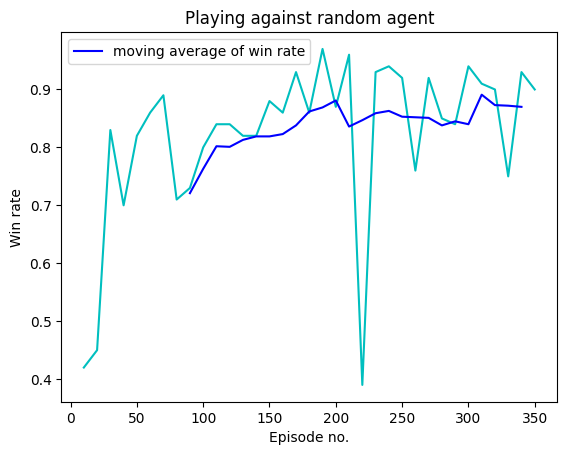

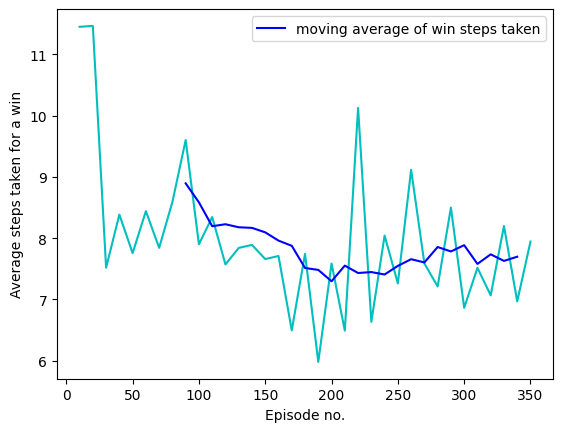

In [132]:
plt.plot(th[:, 0], th[:, 1], c='c')
win_rate_moving_average = np.array([[(i + 9) * 10, np.mean(th[i: i + 10, 1])] for i in range(len(th) - 9)])
plt.plot(win_rate_moving_average[:, 0], win_rate_moving_average[:, 1], c='b', label='moving average of win rate')
plt.legend()
plt.title('Playing against random agent')
plt.xlabel('Episode no.')
plt.ylabel('Win rate')
plt.show()

plt.plot(th[:, 0], th[:, 2], c='c')
win_steps_taken_moving_average = np.array([[(i + 9) * 10, np.mean(th[i: i + 10, 2])] for i in range(len(th) - 9)])
plt.plot(win_steps_taken_moving_average[:, 0], win_steps_taken_moving_average[:, 1], c='b', label='moving average of win steps taken')
plt.legend()
plt.xlabel('Episode no.')
plt.ylabel('Average steps taken for a win')
plt.show()

In [133]:
path = 'DQN_plainCNN.pth'
torch.save(policy_net.state_dict(), path)

In [134]:
def demo():
    env.reset()
    env.render()

    while not env.isDone:
        state = env.board_state.copy()
        available_actions = env.get_available_actions()
        action = select_action(state, available_actions, training=False)
        # trained agent's move is denoted by O
        state, reward = env.make_move(action, 'p1')
        env.render()

        if reward == 1:
            break

        available_actions = env.get_available_actions()
        action = random_agent(available_actions)
        state, reward = env.make_move(action, 'p2')
        env.render()

demo()

,0,1,2,3,4
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,


,0,1,2,3,4
0,,,,,
1,,O,,,
2,,,,,
3,,,,,
4,,,,,


,0,1,2,3,4
0,,,,,X
1,,O,,,
2,,,,,
3,,,,,
4,,,,,


,0,1,2,3,4
0,,,,,X
1,,O,,O,
2,,,,,
3,,,,,
4,,,,,


,0,1,2,3,4
0,,,,,X
1,,O,,O,
2,,,,,X
3,,,,,
4,,,,,


,0,1,2,3,4
0,,,,,X
1,,O,,O,
2,,,,,X
3,,O,,,
4,,,,,


,0,1,2,3,4
0,,,,,X
1,,O,,O,
2,,,X,,X
3,,O,,,
4,,,,,


,0,1,2,3,4
0,,,,,X
1,,O,,O,
2,,,X,,X
3,,O,,O,
4,,,,,


,0,1,2,3,4
0,,,,,X
1,,O,,O,X
2,,,X,,X
3,,O,,O,
4,,,,,


,0,1,2,3,4
0,,,,,X
1,,O,O,O,X
2,,,X,,X
3,,O,,O,
4,,,,,


,0,1,2,3,4
0,,,,X,X
1,,O,O,O,X
2,,,X,,X
3,,O,,O,
4,,,,,


,0,1,2,3,4
0,,,,X,X
1,,O,O,O,X
2,,O,X,,X
3,,O,,O,
4,,,,,


,0,1,2,3,4
0,,,,X,X
1,,O,O,O,X
2,,O,X,,X
3,,O,,O,
4,,,X,,


,0,1,2,3,4
0,,,,X,X
1,,O,O,O,X
2,,O,X,O,X
3,,O,,O,
4,,,X,,


,0,1,2,3,4
0,X,,,X,X
1,,O,O,O,X
2,,O,X,O,X
3,,O,,O,
4,,,X,,


,0,1,2,3,4
0,X,O,,X,X
1,,O,O,O,X
2,,O,X,O,X
3,,O,,O,
4,,,X,,
